In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

In [2]:
filters_models = pd.read_pickle("filters-models.pkl")
filters_models.head()

,fish_id,zone,input_noise_std,model_id,model_filter,model_bias,train_error,valid_error
0,fish,dlz,0.05,0,"[0.006570485, 0.02226457, 0.006591105, 0.05336...",-0.125259,0.234976,0.223262
1,fish,dlz,0.05,1,"[-0.0078074387, -0.015862474, -0.010496924, -0...",-0.112887,0.229159,0.227332
2,fish,dlz,0.05,10,"[-0.025499035, 0.054145638, 0.032702055, 0.031...",-0.088350,0.233271,0.237094
3,fish,dlz,0.05,11,"[-0.0053257598, -0.0764562, 0.030652717, 0.012...",-0.070196,0.231950,0.232991
4,fish,dlz,0.05,12,"[-0.020457136, -0.030005453, 0.03785134, -0.00...",-0.076064,0.228166,0.231957


### Plot distributions of train and valid errors

In [3]:
train_errors = filters_models[["input_noise_std", "train_error", "zone"]].copy()
train_errors["error"] = train_errors["train_error"]
train_errors.drop(columns="train_error", inplace=True)
train_errors["set"] = "train"

valid_errors = filters_models[["input_noise_std", "valid_error", "zone"]].copy()
valid_errors["error"] = valid_errors["valid_error"]
valid_errors.drop(columns="valid_error", inplace=True)
valid_errors["set"] = "valid"

filters_models_errors = pd.concat(
    [train_errors, valid_errors],
    axis=0,
    ignore_index=True,
)

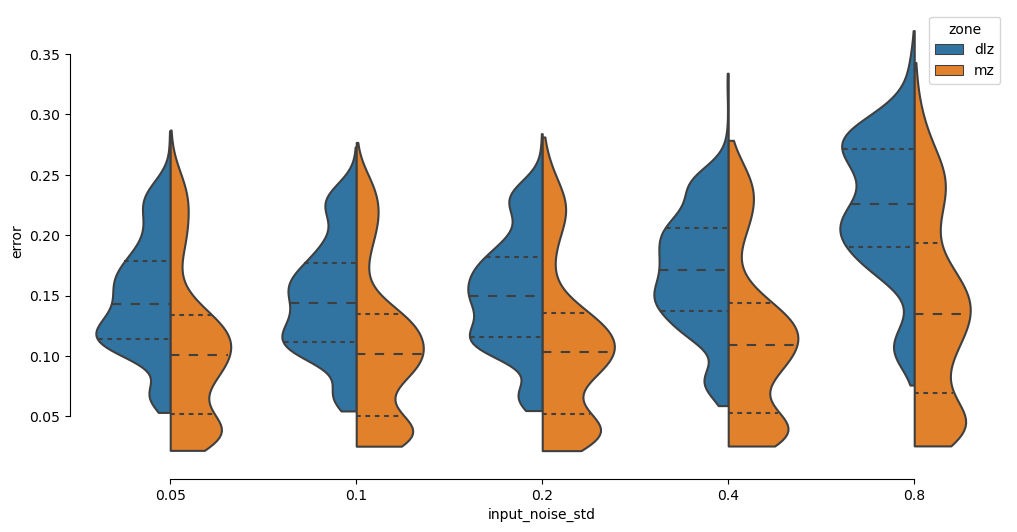

In [4]:
plt.figure(figsize=(12, 6))
sns.violinplot(data=valid_errors, x="input_noise_std", y="error", hue="zone", cut=0, split=True, inner="quart")
# sns.violinplot(data=filters_models_errors, x="input_noise_std", y="error", hue="set", cut=0, split=True, inner="quart")
# sns.violinplot(data=filters_models_errors[filters_models_errors["zone"]=="mz"], x="input_noise_std", y="error", hue="set", cut=0, split=True, inner="quart")
# sns.violinplot(data=filters_models_errors[filters_models_errors["zone"]=="dlz"], x="input_noise_std", y="error", hue="set", cut=0, split=True, inner="quart")
sns.despine(offset=5, trim=True)

(880, 1005)


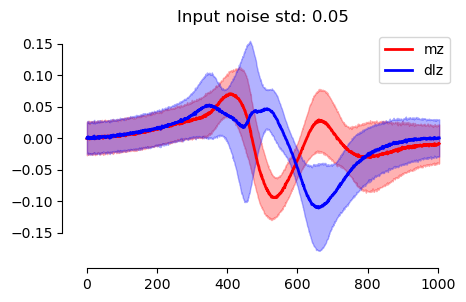

(880, 1005)


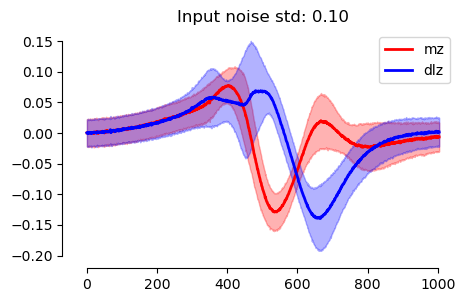

(880, 1005)


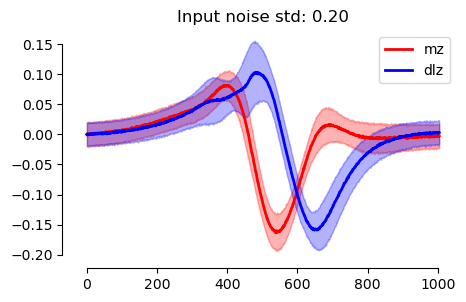

(880, 1005)


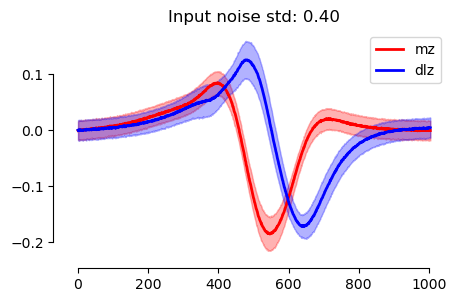

(880, 1005)


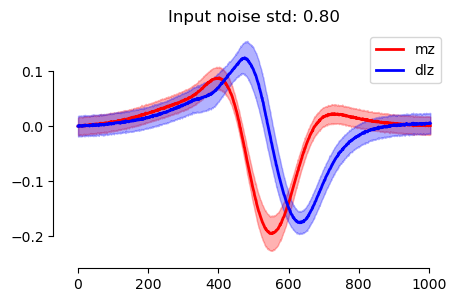

""


In [5]:
def plot_coefficients(df):
    plt.figure(figsize=(5, 3))
    coefficients = np.vstack(df[df["zone"] == "mz"]["model_filter"])
    print(coefficients.shape)
    # plt.plot(coefficients.T, color="black", alpha=0.1, lw=0.1)
    plt.plot(coefficients.mean(axis=0), color="red", lw=2, label="mz")
    plt.fill_between(
        x=np.arange(coefficients.shape[1]),
        y1=coefficients.mean(axis=0) - coefficients.std(axis=0),
        y2=coefficients.mean(axis=0) + coefficients.std(axis=0),
        color="red",
        alpha=0.3,
    )
    coefficients = np.vstack(df[df["zone"] == "dlz"]["model_filter"])
    # plt.plot(coefficients.T, color="black", alpha=0.1, lw=0.1)
    plt.plot(coefficients.mean(axis=0), color="blue", lw=2, label="dlz")
    plt.fill_between(
        x=np.arange(coefficients.shape[1]),
        y1=coefficients.mean(axis=0) - coefficients.std(axis=0),
        y2=coefficients.mean(axis=0) + coefficients.std(axis=0),
        color="blue",
        alpha=0.3,
    )
    sns.despine(offset=5, trim=True)
    plt.title(f"Input noise std: {df['input_noise_std'].iloc[0]:.2f}")
    plt.legend()
    plt.show()
    plt.close()
    pass


filters_models.groupby("input_noise_std").apply(plot_coefficients)